In [20]:
#!pip install pydotplus

In [2]:
#!pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [51]:
#import os
#os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import reciprocal, uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from pprint import pprint
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import math
from scipy import stats 
from sklearn import svm

In [2]:
df1 = pd.read_csv("./marketing_campaigns_train.csv", index_col=0)

In [3]:
X = df1

# Pre-processing

## Missing values


In [4]:
X = X.drop('n_child', axis=1)
X = X.drop('consent', axis=1)
X = X.drop('device', axis=1)
X = X.drop('campaign_type', axis=1)


#complete education
edu_miss_num = X[['age','account_balance','loan','mortgage','credit','positive']].loc[X['education'] == 'unknown']
edu_exist_num = X[['age','account_balance','loan','mortgage','credit','positive']].loc[X['education'] != 'unknown']
ary = scipy.spatial.distance.cdist(edu_miss_num, edu_exist_num, metric='cityblock')
edu_miss_nom = X[['status','education','profession','p_outcome']].loc[X['education'] == 'unknown']
edu_exist_nom = X[['status','education','profession','p_outcome']].loc[X['education'] != 'unknown']
ary2 = scipy.spatial.distance.cdist(edu_miss_nom, edu_exist_nom, metric=lambda u,v: (1/4)*((0 if u[0]==v[0] else 1)+(0 if u[1]==v[1] else 1)+(0 if u[2]==v[2] else 1)+(0 if u[3]==v[3] else 1)))
ary3=(6/10)*(ary)+(4/10)*(ary2)
X['edu2'] = X['education']
for i,j in enumerate(edu_miss_nom.index):
    X.loc[j, 'edu2'] = X.loc[edu_exist_nom[ary3[i]==ary3[i].min()].index]['education'].mode()[0]
X = X.drop('education', axis=1)

#complete profession
pro_miss_num = X[['age','account_balance','loan','mortgage','credit','positive']].loc[X['profession'] == 'unknown']
pro_exist_num = X[['age','account_balance','loan','mortgage','credit','positive']].loc[X['profession'] != 'unknown']
ary = scipy.spatial.distance.cdist(pro_miss_num, pro_exist_num, metric='cityblock')

pro_miss_nom = X[['status','edu2','profession','p_outcome']].loc[X['profession'] == 'unknown']
pro_exist_nom = X[['status','edu2','profession','p_outcome']].loc[X['profession'] != 'unknown']
ary2 = scipy.spatial.distance.cdist(pro_miss_nom, pro_exist_nom, metric=lambda u,v: (1/4)*((0 if u[0]==v[0] else 1)+(0 if u[1]==v[1] else 1)+(0 if u[2]==v[2] else 1)+(0 if u[3]==v[3] else 1)))
                                            
ary3=(6/10)*(ary)+(4/10)*(ary2)
X['pro2'] = X['profession']
for i,j in enumerate(pro_miss_nom.index):
    X.loc[j, 'pro2'] = X.loc[pro_exist_nom[ary3[i]==ary3[i].min()].index]['profession'].mode()[0]

X = X.drop('profession', axis=1)

## Normalization and Outliers

In [6]:
#z-score fitting
z_scaler = StandardScaler()
z_scaler.fit(pd.DataFrame(X['age']))
X['age_norm'] = z_scaler.transform(pd.DataFrame(X['age']))
data_mean, data_std = np.mean(X['age_norm']), np.std(X['age_norm'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
X = X.drop(X.loc[(X['age_norm'] > upper) | (X['age_norm'] < lower)].index)
X = X.drop('age', axis=1)


min_a = abs(X['account_balance'].min())
X['pos_acc'] = X['account_balance'] + min_a
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(X['pos_acc']))
X['account_min_max'] = scaler.transform(pd.DataFrame(X['pos_acc']))
data_mean, data_std = np.mean(X['account_min_max']), np.std(X['account_min_max'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
X = X.drop(X.loc[(X['account_min_max'] > upper) | (X['account_min_max'] < lower)].index)
X = X.drop('account_balance', axis=1)


#normalization
normal_data=X.describe()
normal_data=normal_data.drop(['age_norm','account_min_max'], axis=1)
scaler = MinMaxScaler()
for col in normal_data:
    scaler.fit(pd.DataFrame(X[col]))
    X[col]= scaler.transform(pd.DataFrame(X[col]))

In [7]:
X['Month'] = X['l_date'].str.extract('(\-[A-Za-z]+)', expand=False)
X['Month'] = X['Month'].str.replace('-', '')
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
X['Month'] = pd.Categorical(X['Month'], categories=months, ordered=True)
X.sort_values(by='Month',ascending=True,inplace=True)
X=X.drop('l_date',axis=1)

change catagorical data into numbers

In [8]:
nom = ['pro2','edu2','status','p_outcome','Month']
for cat in nom:
    X[cat+"_cat"] = X[cat].astype('category').cat.codes
for cat in nom:
    X=X.drop(cat,axis=1)

First lets split the target from the rest of the data.<br>
X for the features and Y for the labels. 

In [9]:
Y = X['subscribed']
X = X.drop('subscribed', axis=1)

# Classification

## cross - validation

now to evaluate the model we split the  training data set to train set and test set.<br> we took 25% of the data as validation. <br>
"add to report not here"because: while the norm is 1/3 2/3 the TA recommanded well split like this and i think the reason being the amount of classes that can affect the model decision making so bringing more data will help with that ofc there will be the issue of overfitting but well deal with that later



In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42) 

### simple decision tree
the first model will be a simple decision tree,  train it on the train set and predict the labels to the test set.<br>

In [13]:
# Create Decision Tree classifer object
clf_T = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42) 

# Train Decision Tree Classifer 
clf_T = clf_T.fit(X_train,Y_train)

# Predict the label
t_Y_pred = clf_T.predict(X_test)

### svm model
next well implement the svm model
Hyperparameter:
- C: Regularization, a smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.
- Kernel: The function that used to transform the original training data into a higher dimension.

In [11]:
#check c
clf_svm = svm.SVC(kernel='rbf', C=50,gamma='auto', probability=True)
clf_svm.fit(X_train, Y_train)
svm_Y_pred = clf_svm.predict(X_test)
svm_acu = metrics.accuracy_score(Y_test, svm_Y_pred)

### Random Forest
lastly we have the random forest model

In [15]:
rf = RandomForestClassifier(random_state = 42,n_jobs=-1)
rf.fit(X_train, Y_train)
rf_Y_pred = rf.predict(X_test)

### Naive Bayes classifier 

well add the naive bayes classifier to get some basic comparable results

In [16]:
clf_bg = GaussianNB()
clf_bg.fit(X_train, Y_train)
bg_Y_pred = clf_bg.predict(X_test)

# lets check accurecys and the confusion matrixes

firstly the decision tree algo

In [17]:
print(metrics.accuracy_score(Y_test, t_Y_pred))
pd.DataFrame(metrics.confusion_matrix(Y_test, t_Y_pred))
Tree_accu = metrics.accuracy_score(Y_test, t_Y_pred)

0.8655913978494624


secondly the svm model

In [18]:
print(pd.DataFrame(metrics.confusion_matrix(Y_test, svm_Y_pred)))
print(metrics.classification_report(Y_test,svm_Y_pred))

      0    1
0  6455  117
1   650  218
              precision    recall  f1-score   support

       False       0.91      0.98      0.94      6572
        True       0.65      0.25      0.36       868

    accuracy                           0.90      7440
   macro avg       0.78      0.62      0.65      7440
weighted avg       0.88      0.90      0.88      7440



##### note - although the recall score is the highest, its only the highet for false predictions if the true predictions were with higher recall we would have taken those as the metric,but thats not the case so we will measure the performence of the model through accuracy. 

and lastly the random forest

In [19]:
rf_accuracy = metrics.accuracy_score(Y_test, rf_Y_pred)
print('base model accuracy = {:0.2f}%'.format(rf_accuracy*100))

base model accuracy = 89.83%


### Lets view The ROC Curves

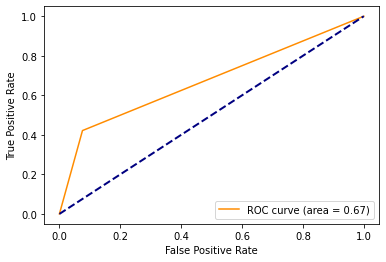

In [20]:
#calculationg for the decision tree
y_probs_d = clf_T.predict_proba(X_test) # probability prediction
fpr_d, tpr_d, _ = metrics.roc_curve(Y_test, y_probs_d[:,1])
auc_d = metrics.auc(fpr_d, tpr_d)
plt.figure()
plt.plot(fpr_d, tpr_d, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_d)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

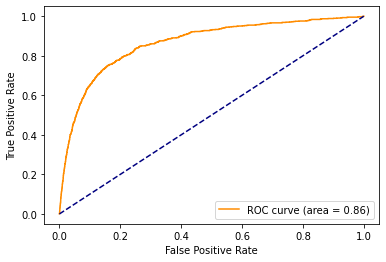

In [21]:
#calculating for the svm model
y_probs_svm = clf_svm.predict_proba(X_test) # probability prediction
fpr_svm, tpr_svm, _ = metrics.roc_curve(Y_test, y_probs_svm[:,1])
auc_svm = metrics.auc(fpr_svm, tpr_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_svm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

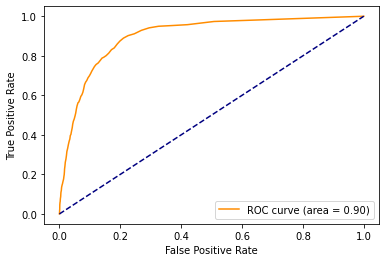

In [22]:
#and lastly calculating for the random forest model
y_probs_rf = rf.predict_proba(X_test) # probability prediction
fpr_rf, tpr_rf, _ = metrics.roc_curve(Y_test, y_probs_rf[:,1])
auc_rf = metrics.auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_rf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparison between the classifiers:
now lets compare results:

In [23]:
clf_list = [clf_T,clf_svm,rf,clf_bg]
cm_dict, auc_dict = {}, {}
kf = KFold(n_splits=10, shuffle=True, random_state=42) #for cross validation
k = 0
for train_index, test_index in kf.split(X):
    k+=1
    print("------",k,"------")
    
    # split to train and test
    X_train_cm, X_test_cm = X.iloc[train_index], X.iloc[test_index]
    y_train_cm, y_test_cm = Y.iloc[train_index], Y.iloc[test_index]
    for clf in clf_list:
        # train the model and make a prediction
        clf.fit(X_train_cm,y_train_cm)
        y_pred_cm = clf.predict(X_test_cm)
        cm = metrics.confusion_matrix(y_test_cm, y_pred_cm)
        y_probs = clf.predict_proba(X_test_cm) # probability prediction
        fpr, tpr, _ = metrics.roc_curve(y_test_cm, y_probs[:,1])
        auc = metrics.auc(fpr, tpr)
        # save the results
        cm_list = cm_dict.get(clf,[])
        cm_list.append(cm)
        cm_dict[clf] = cm_list
        auc_list = auc_dict.get(clf,[])
        auc_list.append(auc)
        auc_dict[clf] = auc_list
        # print the results
        print("Classifier: ", clf)
        print("Accuracy: ", metrics.accuracy_score(y_test_cm, y_pred_cm))

------ 1 ------
Classifier:  DecisionTreeClassifier(random_state=42)
Accuracy:  0.8679435483870968
Classifier:  SVC(C=50, gamma='auto', probability=True)
Accuracy:  0.8948252688172043
Classifier:  RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy:  0.8995295698924731
Classifier:  GaussianNB()
Accuracy:  0.8383736559139785
------ 2 ------
Classifier:  DecisionTreeClassifier(random_state=42)
Accuracy:  0.8608870967741935
Classifier:  SVC(C=50, gamma='auto', probability=True)
Accuracy:  0.8968413978494624
Classifier:  RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy:  0.8948252688172043
Classifier:  GaussianNB()
Accuracy:  0.8366935483870968
------ 3 ------
Classifier:  DecisionTreeClassifier(random_state=42)
Accuracy:  0.8665994623655914
Classifier:  SVC(C=50, gamma='auto', probability=True)
Accuracy:  0.8931451612903226
Classifier:  RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy:  0.9012096774193549
Classifier:  GaussianNB()
Accuracy:  0.836021505376344

In [24]:
acc_dict = {}
prec_dict = {}
for clf in clf_list:
    print(clf)
    acc = [(cm[0][0]+cm[1][1])/sum(sum(cm)) for cm in cm_dict[clf]]
    acc_dict[clf] = acc 
    print("mean accuracy: ", np.mean(acc))
    precision = [(cm[1][1])/(cm[1][1]+cm[0][1]) for cm in cm_dict[clf]]
    prec_dict[clf] = precision
    print("mean precision: ", np.mean(precision))
    print("mean AUC: ", np.mean(auc_dict[clf]))

DecisionTreeClassifier(random_state=42)
mean accuracy:  0.8699596774193548
mean precision:  0.42479860164160915
mean AUC:  0.687884149990499
SVC(C=50, gamma='auto', probability=True)
mean accuracy:  0.8993279569892474
mean precision:  0.6240291748854956
mean AUC:  0.8763635407986465
RandomForestClassifier(n_jobs=-1, random_state=42)
mean accuracy:  0.9052755376344086
mean precision:  0.6303802315438303
mean AUC:  0.9081562615550933
GaussianNB()
mean accuracy:  0.8335685483870968
mean precision:  0.32827940642914166
mean AUC:  0.7934353931856494


### ROC curve
and also while were at it lets compare ROC curves (we like curves :]) but first some calculations

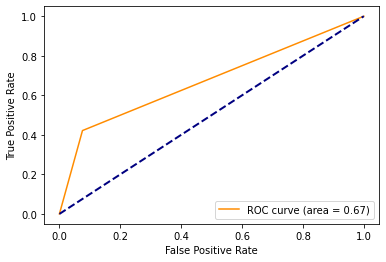

In [34]:
#calculationg for the decision tree
y_probs_d = clf_T.predict_proba(X_test) # probability prediction
fpr_d, tpr_d, _ = metrics.roc_curve(Y_test, y_probs_d[:,1])
auc_d = metrics.auc(fpr_d, tpr_d)
plt.figure()
plt.plot(fpr_d, tpr_d, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_d)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

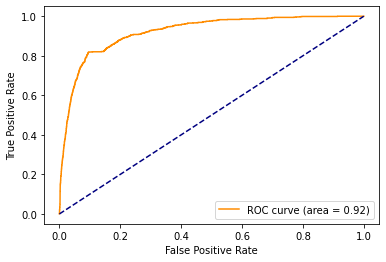

In [24]:
#calculating for the svm model
y_probs_svm = clf_svm.predict_proba(X_test) # probability prediction
fpr_svm, tpr_svm, _ = metrics.roc_curve(Y_test, y_probs_svm[:,1])
auc_svm = metrics.auc(fpr_svm, tpr_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_svm)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

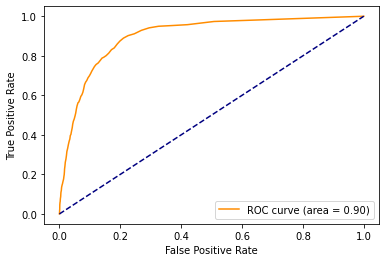

In [30]:
#and lastly calculating for the random forest model
y_probs_rf = rf.predict_proba(X_test) # probability prediction
fpr_rf, tpr_rf, _ = metrics.roc_curve(Y_test, y_probs_rf[:,1])
auc_rf = metrics.auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_rf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

lets check how diffrent our 3 models are from one another (we decided the threshold will be 0.05 which is a standard and also if the models predict the same way [they are equal] we could make changes or throw the one of the models with less accuracy)

In [25]:
#compare tree with svm
ttest,pval = stats.ttest_rel(acc_dict[clf_T], acc_dict[clf_svm])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 1.1619854596919656e-07
reject null hypothesis


In [26]:
#compare tree with rf
ttest,pval = stats.ttest_rel(acc_dict[clf_T], acc_dict[rf])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 1.7080926313343747e-08
reject null hypothesis


In [27]:
#compare rf with svm
ttest,pval = stats.ttest_rel(acc_dict[rf], acc_dict[clf_svm])
print("p-value:" , pval)
if pval<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value: 0.0004444194093560161
reject null hypothesis


In [28]:
#compare all with naive bayes 
clf_list = [clf_T,clf_svm,rf]
for clf in clf_list:
    print(str(clf))
    ttest,pval = stats.ttest_rel(acc_dict[clf_bg], acc_dict[clf_svm])
    print("p-value:" , pval)
    if pval<0.05:
        print("reject null hypothesis")
    else:
        print("accept null hypothesis")

DecisionTreeClassifier(random_state=42)
p-value: 2.667776795298311e-09
reject null hypothesis
SVC(C=50, gamma='auto', probability=True)
p-value: 2.667776795298311e-09
reject null hypothesis
RandomForestClassifier(n_jobs=-1, random_state=42)
p-value: 2.667776795298311e-09
reject null hypothesis


# Now time for some tunning

lets tune the tree: first well look 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.277705 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.277705 to fit



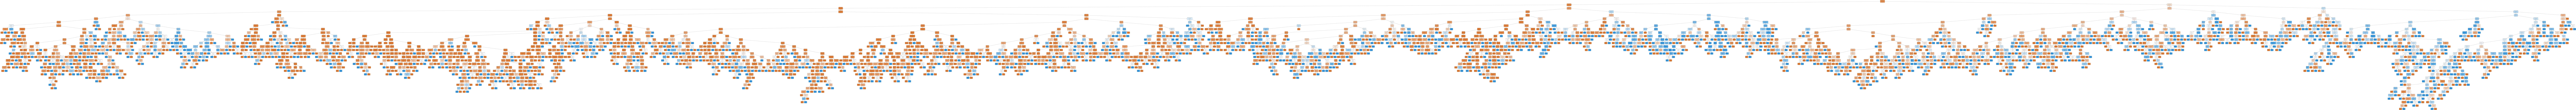

In [35]:
dot = export_graphviz(clf_T, filled=True, rounded=True, 
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('tree1.png')
Image(graph.create_png())

In [66]:
max_features = ['auto', 'log2', 2, 5, 10]
max_depth = [int(x) for x in np.linspace(10, 20, num = 5)]
max_depth.append(None)

min_samples_split = [int(x) for x in np.linspace(math.floor(X.shape[0]/100),(5*math.floor(X.shape[0]/100)),num = 5)]

min_samples_leaf = [int(x) for x in np.linspace(math.floor(X.shape[0]/100),(2*math.floor(X.shape[0]/100)),num = 5)]


random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [10, 12, 15, 17, 20, None],
 'max_features': ['auto', 'log2', 2, 5, 10],
 'min_samples_leaf': [297, 371, 445, 519, 594],
 'min_samples_split': [297, 594, 891, 1188, 1485]}


In [67]:
Tree_random = RandomizedSearchCV(estimator = clf_T, param_distributions = random_grid, n_iter = 200, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1)
Tree_random.fit(X_train,Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.6s finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 15, 17, 20, None],
                                        'max_features': ['auto', 'log2', 2, 5,
                                                         10],
                                        'min_samples_leaf': [297, 371, 445, 519,
                                                             594],
                                        'min_samples_split': [297, 594, 891,
                                                              1188, 1485]},
                   random_state=42, verbose=2)

In [44]:
Tree_random.best_params_

{'min_samples_split': 891,
 'min_samples_leaf': 371,
 'max_features': 10,
 'max_depth': 15}

base model accuracy = 86.56%
random model accuracy = 89.23%
Improvement of 3.09%.


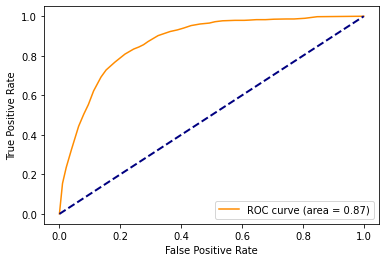

In [68]:
print('base model accuracy = {:0.2f}%'.format(Tree_accu*100))

best_random = Tree_random.best_estimator_
random_t_Y_pred = best_random.predict(X_test)
random_accuracy = metrics.accuracy_score(Y_test, random_t_Y_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - Tree_accu) / Tree_accu))
#calculationg for the decision tree
y_probs_d = best_random.predict_proba(X_test) # probability prediction
fpr_d, tpr_d, _ = metrics.roc_curve(Y_test, y_probs_d[:,1])
auc_d = metrics.auc(fpr_d, tpr_d)
plt.figure()
plt.plot(fpr_d, tpr_d, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_d)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

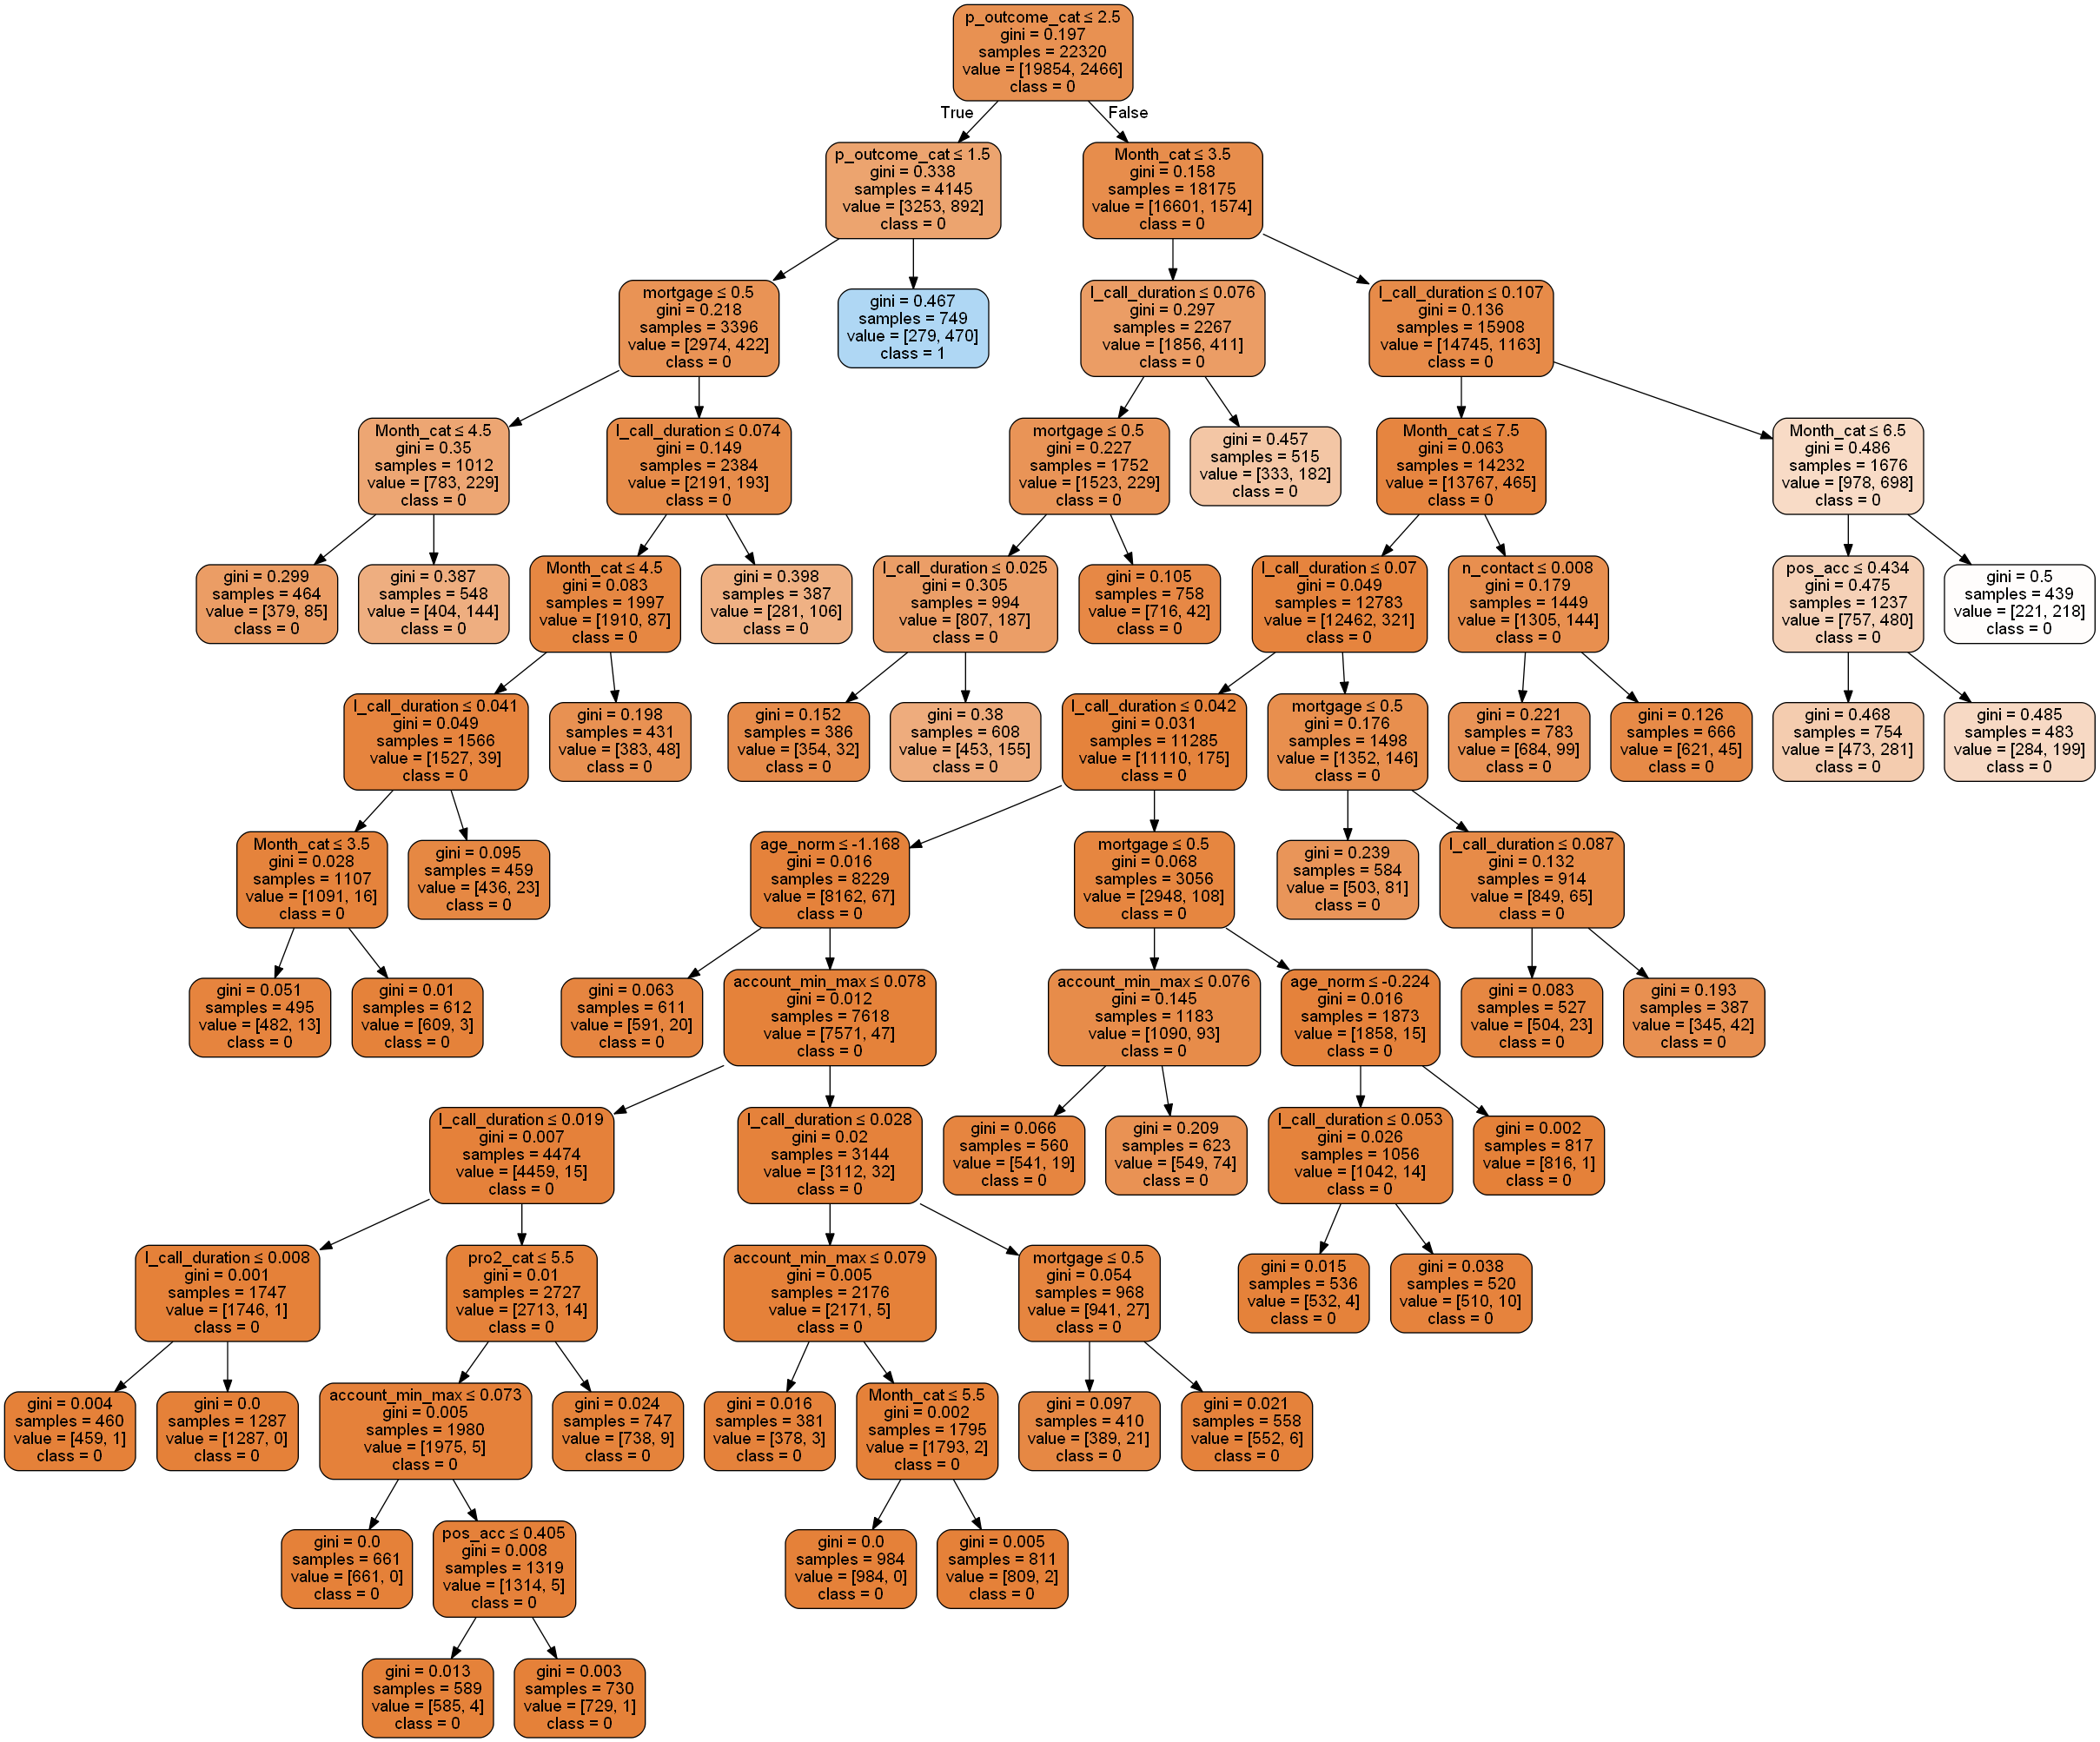

In [46]:
dot = export_graphviz(best_random, filled=True, rounded=True, special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('tree2.png')
Image(graph.create_png())

like in the TA class we need to find good estimates for the algo.

In [69]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_features = ['auto', 'log2', 2, 5, 8]

max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)

min_samples_split = [1, 2, 5, 10, 15, 20]

min_samples_leaf = [1, 2, 5, 10]

max_samples = [0.1, 0.3, 0.5, 0.7, 0.9]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
pprint(random_grid)

{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
 'max_features': ['auto', 'log2', 2, 5, 8],
 'max_samples': [0.1, 0.3, 0.5, 0.7, 0.9],
 'min_samples_leaf': [1, 2, 5, 10],
 'min_samples_split': [1, 2, 5, 10, 15, 20],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


and then lets build the best tree

In [70]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1)

rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.8min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, None],
                                        'max_features': ['auto', 'log2', 2, 5,
                                                         8],
                                        'max_samples': [0.1, 0.3, 0.5, 0.7,
                                                        0.9],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                             

base model accuracy = 89.83%
random model accuracy = 90.00%
Improvement of 0.19%.


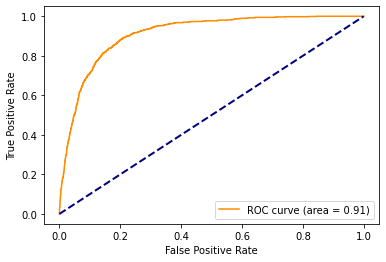

In [71]:
print('base model accuracy = {:0.2f}%'.format(rf_accuracy*100))

best_random = rf_random.best_estimator_
random_y_pred = best_random.predict(X_test)
random_accuracy = metrics.accuracy_score(Y_test, random_y_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - rf_accuracy) / rf_accuracy))
#calculationg for the decision tree
y_probs_d = best_random.predict_proba(X_test) # probability prediction
fpr_d, tpr_d, _ = metrics.roc_curve(Y_test, y_probs_d[:,1])
auc_d = metrics.auc(fpr_d, tpr_d)
plt.figure()
plt.plot(fpr_d, tpr_d, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_d)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

lets tune the svm

In [14]:
C_range = [1,10,25,50]
gamma_range = [0.1,1,10]
random_grid = {'C': C_range,
               'gamma': gamma_range}
random_svm = RandomizedSearchCV(estimator = clf_svm, param_distributions = random_grid, n_iter = 100, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1)
random_svm.fit(X_train,Y_train)

F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 50.8min finished


RandomizedSearchCV(cv=5, estimator=SVC(C=50, gamma='auto', probability=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1, 10, 25, 50],
                                        'gamma': [0.1, 1, 10]},
                   random_state=42, verbose=2)

base model accuracy = 89.69%
random model accuracy = 89.58%
Improvement of -0.12%.


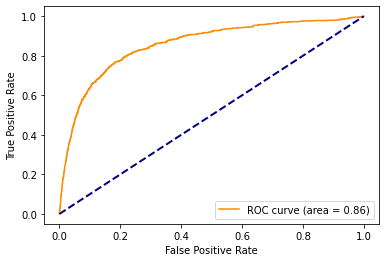

In [16]:
print('base model accuracy = {:0.2f}%'.format(svm_acu*100))

best_svm = random_svm.best_estimator_
random_svm_pred = best_svm.predict(X_test)
random_accuracy = metrics.accuracy_score(Y_test, random_svm_pred)
print('random model accuracy = {:0.2f}%'.format(random_accuracy*100))

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - svm_acu) / svm_acu))

#calculationg for the decision tree
y_probs_d = best_svm.predict_proba(X_test) # probability prediction
fpr_d, tpr_d, _ = metrics.roc_curve(Y_test, y_probs_d[:,1])
auc_d = metrics.auc(fpr_d, tpr_d)
plt.figure()
plt.plot(fpr_d, tpr_d, color='darkorange', label='ROC curve (area = %0.2f)' %  auc_d)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### now after we have chosen our model lets start predicting on the real test file

In [62]:
df2 = pd.read_csv("./marketing_campaigns_test.csv", index_col=0)
real_t = df2

#### pre proccessing

In [63]:
real_t = real_t.drop('n_child', axis=1)
real_t = real_t.drop('device', axis=1)
real_t = real_t.drop('campaign_type', axis=1)


#complete education
edu_miss_num = real_t[['age','account_balance','loan','mortgage','credit','positive']].loc[real_t['education'] == 'unknown']
edu_exist_num = real_t[['age','account_balance','loan','mortgage','credit','positive']].loc[real_t['education'] != 'unknown']
ary = scipy.spatial.distance.cdist(edu_miss_num, edu_exist_num, metric='cityblock')
edu_miss_nom = real_t[['status','education','profession','p_outcome']].loc[real_t['education'] == 'unknown']
edu_exist_nom = real_t[['status','education','profession','p_outcome']].loc[real_t['education'] != 'unknown']
ary2 = scipy.spatial.distance.cdist(edu_miss_nom, edu_exist_nom, metric=lambda u,v: (1/4)*((0 if u[0]==v[0] else 1)+(0 if u[1]==v[1] else 1)+(0 if u[2]==v[2] else 1)+(0 if u[3]==v[3] else 1)))
ary3=(6/10)*(ary)+(4/10)*(ary2)
real_t['edu2'] = real_t['education']
for i,j in enumerate(edu_miss_nom.index):
    real_t.loc[j, 'edu2'] = real_t.loc[edu_exist_nom[ary3[i]==ary3[i].min()].index]['education'].mode()[0]
real_t = real_t.drop('education', axis=1)

#complete profession
pro_miss_num = real_t[['age','account_balance','loan','mortgage','credit','positive']].loc[real_t['profession'] == 'unknown']
pro_exist_num = real_t[['age','account_balance','loan','mortgage','credit','positive']].loc[real_t['profession'] != 'unknown']
ary = scipy.spatial.distance.cdist(pro_miss_num, pro_exist_num, metric='cityblock')

pro_miss_nom = real_t[['status','edu2','profession','p_outcome']].loc[real_t['profession'] == 'unknown']
pro_exist_nom = real_t[['status','edu2','profession','p_outcome']].loc[real_t['profession'] != 'unknown']
ary2 = scipy.spatial.distance.cdist(pro_miss_nom, pro_exist_nom, metric=lambda u,v: (1/4)*((0 if u[0]==v[0] else 1)+(0 if u[1]==v[1] else 1)+(0 if u[2]==v[2] else 1)+(0 if u[3]==v[3] else 1)))
                                            
ary3=(6/10)*(ary)+(4/10)*(ary2)
real_t['pro2'] = real_t['profession']
for i,j in enumerate(pro_miss_nom.index):
    real_t.loc[j, 'pro2'] = real_t.loc[pro_exist_nom[ary3[i]==ary3[i].min()].index]['profession'].mode()[0]
real_t = real_t.drop('profession', axis=1)

#z-score fitting
z_scaler = StandardScaler()
z_scaler.fit(pd.DataFrame(real_t['age']))
real_t['age_norm'] = z_scaler.transform(pd.DataFrame(real_t['age']))

data_mean, data_std = np.mean(real_t['age_norm']), np.std(real_t['age_norm'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
real_t = real_t.drop(real_t.loc[(real_t['age_norm'] > upper) | (real_t['age_norm'] < lower)].index)
real_t = real_t.drop('age', axis=1)


min_a = abs(real_t['account_balance'].min())
real_t['pos_acc'] = real_t['account_balance'] + min_a
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(real_t['pos_acc']))
real_t['account_min_max'] = scaler.transform(pd.DataFrame(real_t['pos_acc']))
data_mean, data_std = np.mean(real_t['account_min_max']), np.std(real_t['account_min_max'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
real_t = real_t.drop(real_t.loc[(real_t['account_min_max'] > upper) | (real_t['account_min_max'] < lower)].index)
real_t = real_t.drop('account_balance', axis=1)


#normalization
normal_data=real_t.describe()
normal_data=normal_data.drop(['age_norm','account_min_max'], axis=1)
scaler = MinMaxScaler()
for col in normal_data:
    scaler.fit(pd.DataFrame(real_t[col]))
    real_t[col]= scaler.transform(pd.DataFrame(real_t[col]))
real_t['Month'] = real_t['l_date'].str.extract('(\-[A-Za-z]+)', expand=False)
real_t['Month'] = real_t['Month'].str.replace('-', '')
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
real_t['Month'] = pd.Categorical(real_t['Month'], categories=months, ordered=True)
real_t.sort_values(by='Month',ascending=True,inplace=True)
real_t = real_t.drop('l_date',axis=1)
nom = ['pro2','edu2','status','p_outcome','Month']
for cat in nom:
    real_t[cat+"_cat"] = real_t[cat].astype('category').cat.codes
for cat in nom:
    real_t = real_t.drop(cat,axis=1)

In [65]:
real_t['subscribed'] = best_random.predict(real_t)
real_t.to_csv('predictions.csv')